In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

from pathlib import Path
import json
import pickle
from utils import load_arguments, get_boxed_answer
from latex_formater import get_final_answer, process_docs, process_results, is_equiv
# from model_generate import load_datasets, prompt_generator, load_model
# from blocks import Batch, Block
import itertools
from tqdm import tqdm
import pandas as pd

root_dir = Path('~/model_evals/').expanduser()

# load the name maps
with open('name_maps.json', 'r') as f:
    name_maps = json.load(f)
    DATASET_MAP = name_maps['DATASET_MAP']
    MODEL_MAP = name_maps['MODEL_MAP']

In [112]:
with open('/lfs/ampere8/0/kaif/model_evals/Algebra_test/Llama-2-7b/teacher_forcing/output.pkl', 'rb') as f:
    temp = pickle.load(f)
    
temp[0]['raw']['solution_ids'].shape

torch.Size([60])

In [117]:
temp[0]

{'tfa': 0.5,
 'tfce': 1.5751442909240723,
 'perpelexity': 4.831438700572437,
 'sumCE': 94.50865936279297,
 'bpc': 1.1085136112501277,
 'total_num_tokens': 788,
 'prompt_num_tokens': 728,
 'solution_num_tokens': 60,
 'total_num_chars': 2039,
 'prompt_num_chars': 1916,
 'solution_num_chars': 123,
 'raw': {'teacher_forced_ids': tensor([12024, 24968,   310,   278,  1196,  6819,  2183,  1154, 29912, 29895,
          29929, 29896,  1157, 29929, 29899, 29896,  1012,  1884, 29912, 29906,
           1504,   577,   278,  2521, 29912, 29896,  1157, 29900,  1157, 29929,
          29929, 29899, 29955,  8738,  1154, 29896, 29906,  1504,   607,   395,
          29895, 29922, 29896, 29922,  1884, 29912, 29896, 29929,  1157, 29896,
           4311,   470,   395, 29895, 29922,  1154,   287, 29912, 29945,  4311]),
  'solution_ids': tensor([ 1576, 24968,   310,   278,  1196,   338,   779,  1154, 29912, 29896,
          29899, 29900,  1157, 29929, 29899, 29955,  8738,  1154, 29896, 29906,
           1628, 

In [93]:
def load_predictions(path):
    if not (path / 'output.pkl').exists():
        return []
    print(path)
    with open(path / 'output.pkl', 'rb') as f:
        return pickle.load(f)


raw_predictions = pd.DataFrame([
    {
        'dataset': dataset.name,
        'model': model.name,
        'method': method.name,
        'prediction': prediction,
        'i': i,
        'generation_args': load_arguments(method / 'args.json')
    }
    for dataset in tqdm(list(root_dir.iterdir())[:1])
    for model in dataset.iterdir()
    for method in model.iterdir()
    for i, prediction in enumerate(load_predictions(method))
])
args = raw_predictions.iloc[0]['generation_args']

  0%|                                                                                                                | 0/1 [00:00<?, ?it/s]

/lfs/ampere8/0/kaif/model_evals/Algebra_test/Mistral-7b-Instruct-v0.2/teacher_forcing
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Mistral-7b-Instruct-v0.2/autoregressive
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Gemma-1.1-7b-Instruct/teacher_forcing
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Gemma-1.1-7b-Instruct/autoregressive
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Gemma-7b-Instruct/teacher_forcing
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Gemma-7b-Instruct/autoregressive
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Mixtral-8x7b-Instruct-v0.1/teacher_forcing
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Mixtral-8x7b-Instruct-v0.1/autoregressive
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Deepseek-7b-RL/teacher_forcing
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Deepseek-7b-RL/autoregressive
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Llama-2-13b/teacher_forcing
/lfs/ampere8/0/kaif/model_evals/Algebra_test/Llama-2-13b/autoregressive
/lfs/ampere8/0/kaif/model_evals/Alge

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.55s/it]

/lfs/ampere8/0/kaif/model_evals/Algebra_test/Deepseek-7b-Instruct/autoregressive


In [107]:
predictions = raw_predictions.query('method == "teacher_forcing"')
(len(predictions), len(raw_predictions))

(102, 17907)

In [111]:
predictions['prediction'].iloc[3]['raw']['solution_ids'].shape

torch.Size([60])

/tmp/user/21882/ipykernel_4185487/3448453564.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = predictions.groupby(['dataset', 'model', 'method']).apply(lambda x: x.sample(1)).reset_index(drop=True)
/lfs/ampere8/0/kaif/miniforge/envs/TheoremSense2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/lfs/ampere8/0/kaif/miniforge/envs/TheoremSense2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version.

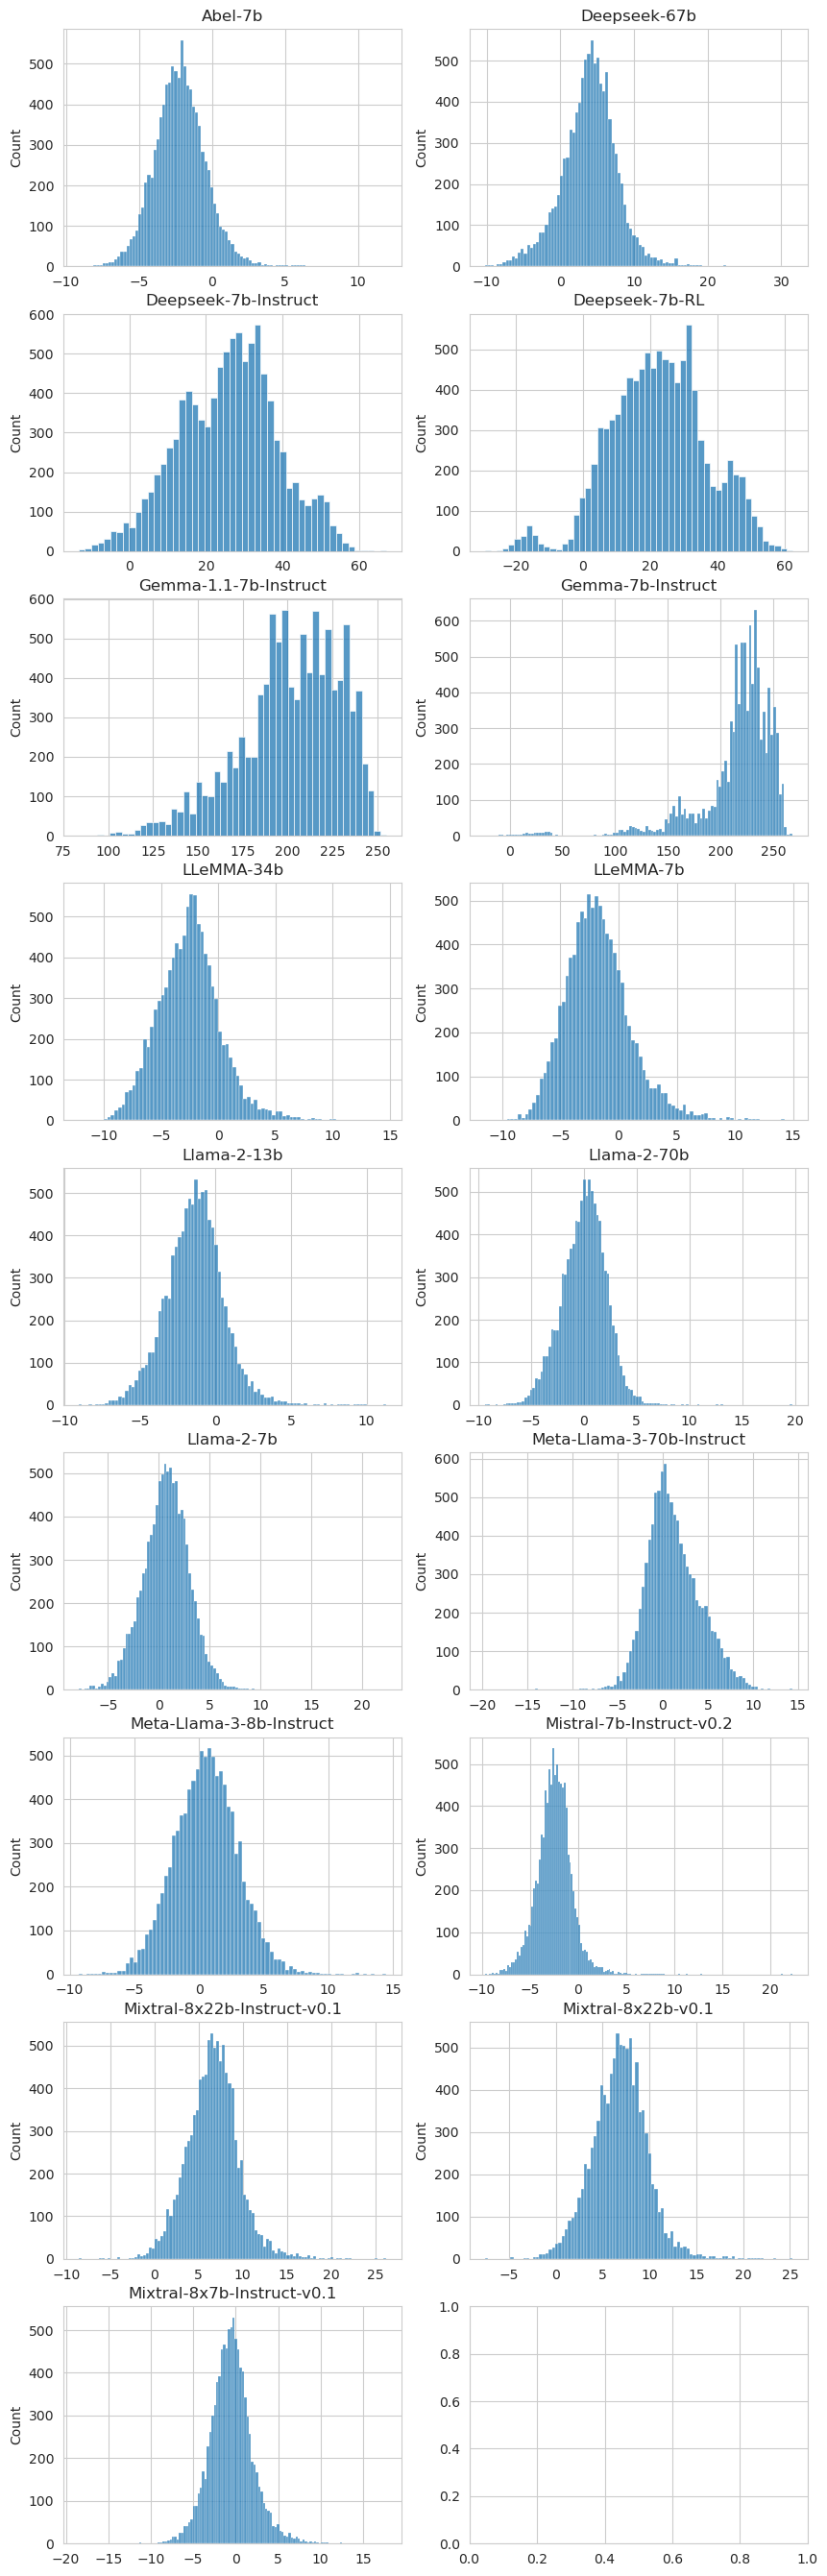

In [20]:
# plot distribution of logits for each model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# take sample of predictions for each model
sample = predictions.groupby(['dataset', 'model', 'method']).apply(lambda x: x.sample(1)).reset_index(drop=True)
sample['logits'] = sample['prediction'].apply(lambda x: x['raw']['teacher_forced_logits'])
sample['solution_ids'] = sample['prediction'].apply(lambda x: x['raw']['solution_ids'])

# plot the logits
num_models = sample['model'].nunique()
fig, axes = plt.subplots(num_models // 2 + 1, 2, figsize=(10, num_models * 2))
for i, (model, group) in enumerate(sample.groupby('model')):
    ax = axes[i // 2, i % 2]
    logits = np.concatenate(group['logits'].values).flatten()
    # sample
    logits2 = np.random.choice(logits, 10000)
    sns.histplot(logits2, ax=ax)
    ax.set_title(model)
plt.show()

In [95]:
# plot distribution of logits for each model and prediction i and word w
i = 0
w = 0
# select where i = i
sample = predictions.groupby(['dataset', 'model', 'method']).apply(lambda x: x.iloc[i]).reset_index(drop=True)
sample['logits'] = sample['prediction'].apply(lambda x: x['raw']['teacher_forced_logits'])
sample['solution_ids'] = sample['prediction'].apply(lambda x: x['raw']['solution_ids'])
# compute average logits for top k words
sample['word_logits'] = sample['logits'].apply(lambda x: np.mean(np.sort(x, axis=1), axis=0))

# plot the logits
num_models = sample['model'].nunique()
# fig, axes = plt.subplots(num_models // 2 + 1, 2, figsize=(10, num_models * 2))
plt.figure(figsize=(10, 10))
for i, (model, group) in enumerate(sample.groupby('model')):
    # ax = axes[i // 2, i % 2]
    logits = group['word_logits'].values[0]
    # subtract mean
    logits = logits - logits.mean()
    # ax.set_title(model)
    # sort logits
    logits = np.sort(logits)[::-1][:50]
    plt.plot(np.linspace(0, 1, len(logits)), logits, label=f'{len(logits) // 1000}k {model}', marker=['o', 'x', 's', 'v'][i % 4])
plt.legend()
plt.show()

/tmp/user/21882/ipykernel_4185487/86457622.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = predictions.groupby(['dataset', 'model', 'method']).apply(lambda x: x.iloc[i]).reset_index(drop=True)


TypeError: string indices must be integers

In [97]:
predictions['prediction'].iloc[0]

{'tfa': 0.7333333492279053,
 'tfce': 1.1034737825393677,
 'perpelexity': 3.014619990316225,
 'sumCE': 66.20842742919922,
 'bpc': 0.776573739163923,
 'total_num_tokens': 799,
 'prompt_num_tokens': 739,
 'solution_num_tokens': 60,
 'total_num_chars': 2039,
 'prompt_num_chars': 1916,
 'solution_num_chars': 123,
 'raw': {'teacher_forced_ids': tensor([ 2324,  1407,   302,   272,  1407,  9720,  2078,  1655, 28751, 28724,
          28774, 28734,  1400, 28774, 28733, 28787, 11241,  1655, 28751, 28750,
           1715,   579,   272, 20999, 28751, 28729, 28733, 28740,  1400, 28740,
          28774, 28733, 28774, 11241,  1655, 28740, 28750,  1715,   690,   429,
          28729, 28746, 28740,  2568,  1655, 28740, 28740,  1400,  1400, 28750,
           5070,   304,   429, 28729,  2568,  2858,   286, 28751, 28784,  5124]),
  'solution_ids': tensor([ 1014, 20912,   302,   272,  1407,   349,   878,  1655, 28751, 28740,
          28733, 28734,  1400, 28774, 28733, 28787, 11241,  1655, 28740, 28750,
   

In [104]:
predictions['method'].unique()

array(['teacher_forcing', 'autoregressive'], dtype=object)

In [103]:
# compute min-k score to detect overfitting
# The MIN-K% PROB approach selects the k% tokens in a given example with minimum
# probabilities, if the average probability of these tokens is high, then the example is likely to
# be present in the pretraining data. We define the MIN-K% Score to be the average negative
# log-likelihood of these selected tokens
k = 20
from torch.nn.functional import log_softmax, softmax
import torch
# compute log probs


def temp(x):
    try:
        print(x['raw']['teacher_forced_logits'].shape)
    except:
        print(x)
        raise ValueError
    # raise ValueError

predictions['prediction'].apply(temp)

predictions['log_probs'] = predictions['prediction'].apply(lambda x: log_softmax(x['raw']['teacher_forced_logits'], dim=1))

# get log probs of chosen tokens in the sequence each log_prob is of shape (seq_len, vocab_size)
# result should be of shape (seq_len,)
def get_chosen_log_probs(log_probs, solution_ids):
    return torch.gather(log_probs, 1, solution_ids.unsqueeze(1)).squeeze(1)
predictions['chosen_log_probs'] = predictions.apply(lambda x: get_chosen_log_probs(x['log_probs'], x['prediction']['raw']['solution_ids']), axis=1)

# compute min-k score
predictions['min_k_score'] = predictions['chosen_log_probs'].apply(lambda x: -np.sort(x.cpu().numpy())[:k].mean())

torch.Size([60, 32000])
torch.Size([84, 32000])
torch.Size([109, 32000])
torch.Size([60, 32000])
torch.Size([84, 32000])
torch.Size([109, 32000])

We can find the possible values of $x$ that make the denominator zero and determine if these correspond to vertical asymptotes. The denominator is equal to zero when $x^2+x-6=0$, which is equivalent to $(x+3)(x-2)=0$. So, the possible values of $x$ are $x=-3$ and $x=2$. We must check if each of these values leads to a vertical asymptote. For $x=-3$, as $x$ gets closer to $-3$ from the right, the value of the function gets larger and larger in absolute value, so there is a vertical asymptote at $x=-3$. Similarly, for $x=2$, as $x$ gets closer to $2$ from the left, the value of the function gets larger and larger in absolute value, so there is a vertical asymptote at $x=2$. Therefore, there are two vertical asymptotes.
Final Answer: The final answer is two. I hope it is correct.

Problem:
Find the equation of the parabola that passes through t

ValueError: 

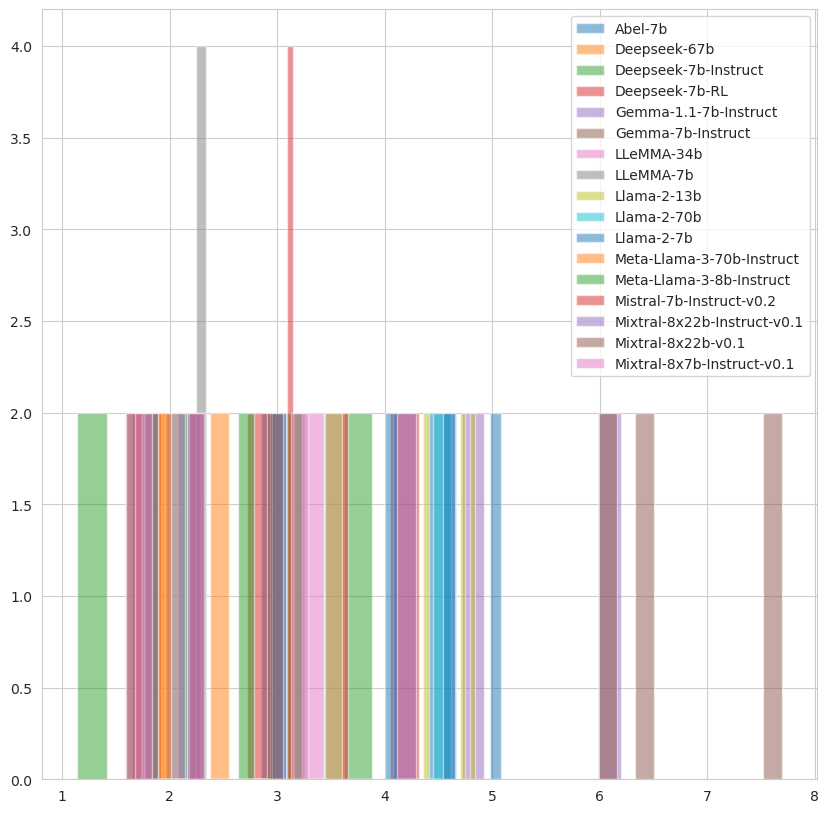

In [85]:
# plot min-k score
plt.figure(figsize=(10, 10))
for i, (model, group) in enumerate(predictions.groupby('model')):
    plt.hist(group['min_k_score'], alpha=0.5, label=model)
plt.legend()
plt.show()

In [70]:
predictions['prediction'].iloc[0]['raw']['solution_ids'].shape, predictions['log_probs'].iloc[0].shape

(torch.Size([60, 1]), torch.Size([60, 32000]))

In [80]:
predictions['chosen_log_probs'].iloc[0].shape

torch.Size([60])